In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import resize
import math
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import os
import random
import tqdm
from tqdm import tqdm
import json
from tensorflow.keras.utils import plot_model

# Get Data

In [ ]:
def crop_img(img,th=0):
  minX = 0
  while minX < img.shape[1] and (np.all((img[:,minX,:]<=th))):
    minX += 1
  maxX = img.shape[1]-1
  while maxX >= 0 and (np.all((img[:,maxX,:]<=th))):
    maxX -= 1

  minY = 0
  while minY < img.shape[0] and (np.all((img[minY,:,:]<=th))):
    minY += 1
  maxY = img.shape[0]-1
  while maxY >= 0 and (np.all((img[maxY,:,:]<=th))):
    maxY -= 1

  return img[minY:maxY+1,minX:maxX+1,:]

def crop_pil(pilimg,th=0):
  img = np.asarray(pilimg)
  return crop_img(img,th)

In [ ]:
def transform(img,
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]):
  img = crop_img(img)
  img = resize(img,(448,448))
  img = img/255.
  img = img - np.array(mean)
  img = img / np.array(std)
  return img

def get_img(patient,key):
  img = np.asarray(Image.open(f'/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/{patient}/{key}'))
  return transform(img)

def load_img(path):
  img = np.asarray(Image.open(path))
  return transform(img)

In [ ]:
def get_patient(patient):
  ann_lines = open(f'/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/{patient}/{patient}.txt').readlines()
  paths = []
  labels = []
  for line in ann_lines:
    splitline = line.split()
    paths.append(f'/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/{patient}/{splitline[0]}')
    x1,y1,z1 = map(float, splitline[21:24])
    x2,y2,z2 = map(float, splitline[24:27])
    x = x2 - x1
    y = y2 - y1
    z = z2 - z1

    norm = np.linalg.norm([x,y,z])
    x /= norm
    y /= norm
    z /= norm

    theta = math.asin(-y)*180./np.pi
    if theta < 0: theta += 360.
    phi = math.atan2(-x,-z)*180./np.pi
    if phi < 0: phi += 360.

    labels.append(np.array([theta,phi]))

  paths, labels = shuffle(paths,labels,random_state=42)
  return paths, labels

In [ ]:
def get_dataset(patients):
  paths = []
  labels = []

  for patient in patients:
    p, l = get_patient(patient)
    paths.extend(p)
    labels.extend(l)

  return Dataset(paths,labels)

class Dataset(tf.keras.utils.Sequence):
  def __init__(self,paths,labels,batch_size=1):
    self.paths = paths
    self.labels = labels
    self.batch_size=batch_size

  def __len__(self):
    return int(np.ceil(len(self.paths)/self.batch_size))

  def __getitem__(self,i):
    batch_x = []
    batch_y = []

    for j in range(i*self.batch_size, (i+1)*self.batch_size):
      if j >= len(self.paths): break
      batch_x.append(load_img(self.paths[i]))
      batch_y.append(self.labels[i])

    return np.array(batch_x), np.array(batch_y)

In [ ]:
patients = [p for p in os.listdir('/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/') if 'p' in p and '.' not in p]
random.Random(42).shuffle(patients)

In [ ]:
train_gen = get_dataset(patients[:11])
val_gen = get_dataset(patients[11:13])
test_gen = get_dataset(patients[13:])

# Make Model

In [ ]:
!pip install -U -q tensorflow-addons
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 50
image_size = 448

num_classes = 2
input_shape = (448, 448, 3)

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255)
    ],
    name="data_augmentation",
)

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    #augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs) #cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes, activation='relu')(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[
            'mse'
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/cct_model_weights.hdf5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=train_gen,
        epochs=num_epochs,
        validation_data=val_gen,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    return model, history

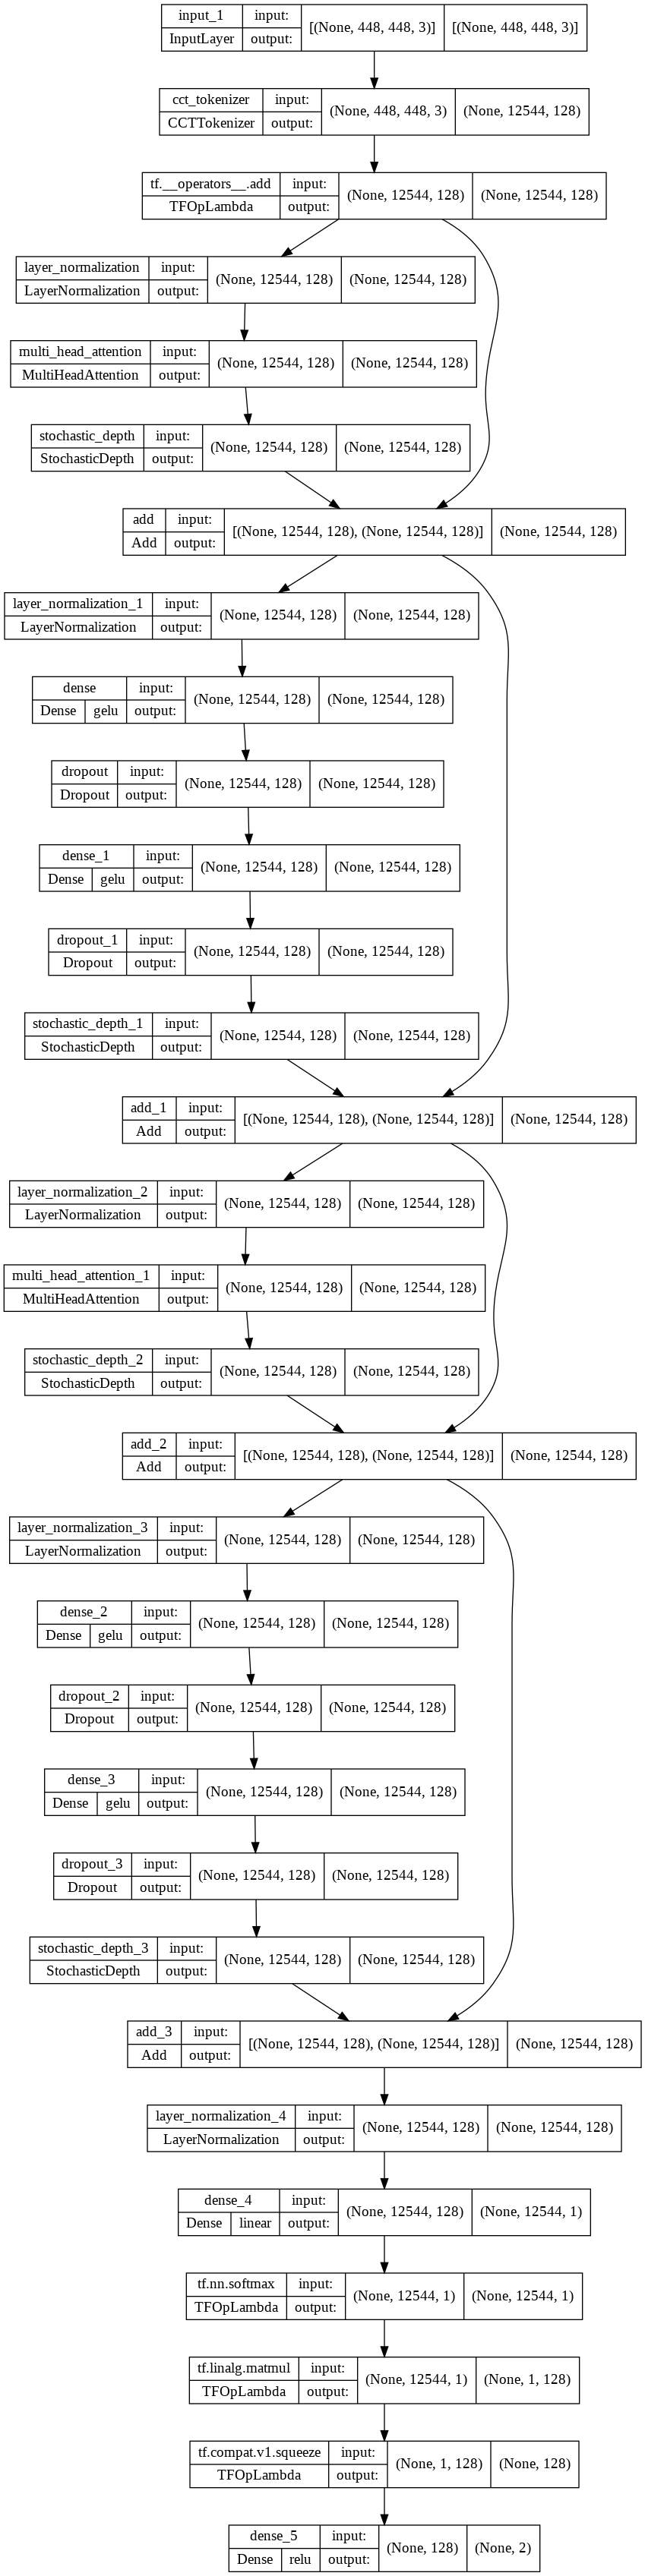

In [ ]:
cct_model = create_cct_model()
plot_model(cct_model, show_shapes=True, show_layer_activations=True)

In [ ]:
cct_model, cct_history = run_experiment(cct_model)
json.dump(cct_history.history, open('/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/cct_history.json','w'))

Epoch 1/50
28807/28807 [==============================] - 10398s 361ms/step - loss: 22286.2461 - mse: 22286.2461 - val_loss: 19136.1133 - val_mse: 19136.1133
Epoch 2/50
28807/28807 [==============================] - 9396s 326ms/step - loss: 21519.4785 - mse: 21519.4785 - val_loss: 19418.3008 - val_mse: 19418.3008
Epoch 3/50
28807/28807 [==============================] - 9397s 326ms/step - loss: 21516.3926 - mse: 21516.3926 - val_loss: 18971.5391 - val_mse: 18971.5391
Epoch 4/50
28807/28807 [==============================] - 9404s 326ms/step - loss: 21515.9297 - mse: 21515.9297 - val_loss: 18975.1836 - val_mse: 18975.1836
Epoch 5/50
26061/28807 [==========================>...] - ETA: 14:24 - loss: 21468.9395 - mse: 21468.9395

In [ ]:
print(cct_model.evaluate(test_gen))